In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sympy as sym
from sympy import symbols, simplify, lambdify
from sympy.vector import CoordSys3D, matrix_to_vector

import scipy
from scipy.integrate import solve_ivp

from geometry_util import pol2cart, cart2pol, r_ort, tet_ort, phi_ort
from material import StaticMaterial, Material, LayeredFilm, print_film_parameters, print_Hext_parameters

In [2]:
def Energy2Heff(energy, varset, Mx, My, Mz):
    Hx = simplify(-sym.diff(energy, Mx))
    Hy = simplify(-sym.diff(energy, My))
    Hz = simplify(-sym.diff(energy, Mz))
    
    Hx_l = lambdify(varset, Hx, 'numpy')
    Hy_l = lambdify(varset, Hy, 'numpy')
    Hz_l = lambdify(varset, Hz, 'numpy')
    
    return (Hx, Hy, Hz), (Hx_l, Hy_l, Hz_l) 

In [3]:
class DemagnetizationEnergy:
    def __init__(self):
        S = CoordSys3D('S')
        Mx, My, Mz = symbols("M_x M_y M_z")
        
        self.E_eq = 2*sym.pi*(Mz**2)
        
        self.varset = (Mz,)
        self.H_eq, self.H_l = Energy2Heff(self.E_eq, self.varset, Mx, My, Mz)
        
    def Heff(self, M):
        return np.array([
            self.H_l[0](M[2]),
            self.H_l[1](M[2]),
            self.H_l[2](M[2])
        ])


    
demagnet_eq = DemagnetizationEnergy()

display(demagnet_eq.E_eq)
print("Heff:")
display(demagnet_eq.H_eq[0])
display(demagnet_eq.H_eq[1])
display(demagnet_eq.H_eq[2])

2*pi*M_z**2

Heff:


0

0

-4*pi*M_z

In [4]:
class StoenerWolfarthEnergy:
    def __init__(self):
        S = CoordSys3D('S')
        
        Ku_1ord = symbols("K_u^1ord")
        Mx, My, Mz = symbols('M_x M_y M_z')
        M = Mx*S.i + My*S.j + Mz*S.k
        
        sin_tet_sqr = (Mx**2 + My**2)/(Mx**2 + My**2 + Mz**2)
        self.E_eq = Ku_1ord*sin_tet_sqr
        
        self.varset = (Ku_1ord, Mx, My, Mz)
        self.H_eq, self.H_l = Energy2Heff(self.E_eq, self.varset, Mx, My, Mz)
    
    
    def Heff(self, M, Ku_1ord):
        return np.array([
            self.H_l[0](Ku_1ord, M[0], M[1], M[2]),
            self.H_l[1](Ku_1ord, M[0], M[1], M[2]),
            self.H_l[2](Ku_1ord, M[0], M[1], M[2])
        ])


    
StWo_eq = StoenerWolfarthEnergy()

display(StWo_eq.E_eq)
print("Heff:")
display(StWo_eq.H_eq[0])
display(StWo_eq.H_eq[1])
display(StWo_eq.H_eq[2])

K_u^1ord*(M_x**2 + M_y**2)/(M_x**2 + M_y**2 + M_z**2)

Heff:


-2*K_u^1ord*M_x*M_z**2/(M_x**2 + M_y**2 + M_z**2)**2

-2*K_u^1ord*M_y*M_z**2/(M_x**2 + M_y**2 + M_z**2)**2

2*K_u^1ord*M_z*(M_x**2 + M_y**2)/(M_x**2 + M_y**2 + M_z**2)**2

In [5]:
class StoenerWolfarth_2nd_order_Energy:
    def __init__(self):
        S = CoordSys3D('S')
        
        Ku_2ord = symbols("K_u^2ord")
        Mx, My, Mz = symbols('M_x M_y M_z')
        M = Mx*S.i + My*S.j + Mz*S.k
        
        sin_tet_sqr = (Mx**2 + My**2)/(Mx**2 + My**2 + Mz**2)
        self.E_eq = Ku_2ord*(sin_tet_sqr**2)
        
        self.varset = (Ku_2ord, Mx, My, Mz)
        self.H_eq, self.H_l = Energy2Heff(self.E_eq, self.varset, Mx, My, Mz)
    
    
    def Heff(self, M, Ku_2ord):
        return np.array([
            self.H_l[0](Ku_2ord, M[0], M[1], M[2]),
            self.H_l[1](Ku_2ord, M[0], M[1], M[2]),
            self.H_l[2](Ku_2ord, M[0], M[1], M[2])
        ])
    
    
StWo_2nd_eq = StoenerWolfarth_2nd_order_Energy()

display(StWo_2nd_eq.E_eq)
print("Heff:")
display(StWo_2nd_eq.H_eq[0])
display(StWo_2nd_eq.H_eq[1])
display(StWo_2nd_eq.H_eq[2])

K_u^2ord*(M_x**2 + M_y**2)**2/(M_x**2 + M_y**2 + M_z**2)**2

Heff:


-4*K_u^2ord*M_x*M_z**2*(M_x**2 + M_y**2)/(M_x**2 + M_y**2 + M_z**2)**3

-4*K_u^2ord*M_y*M_z**2*(M_x**2 + M_y**2)/(M_x**2 + M_y**2 + M_z**2)**3

4*K_u^2ord*M_z*(M_x**2 + M_y**2)**2/(M_x**2 + M_y**2 + M_z**2)**3

In [6]:
class IEC_Energy:
    def __init__(self):
        S = CoordSys3D('S')
        
        J, t = symbols("J t")
        
        Mx1, My1, Mz1 = symbols('M_x1 M_y1 M_z1')
        M1 = Mx1*S.i + My1*S.j + Mz1*S.k
        
        Mx2, My2, Mz2 = symbols('M_x2 M_y2 M_z2')
        M2 = Mx2*S.i + My2*S.j + Mz2*S.k
        
        self.E_eq = (J/t)*M1.dot(M2)/(M1.magnitude()*M2.magnitude())
        
        self.varset = (
            J, t,
            Mx1, My1, Mz1,
            Mx2, My2, Mz2
        )
        
        self.H_eq, self.H_l = Energy2Heff(self.E_eq, self.varset, Mx1, My1, Mz1)
        
    def Heff(self, M_for, M_other, J, t_for):
        return np.array([
            self.H_l[0](J, t_for, M_for[0], M_for[1], M_for[2], M_other[0], M_other[1], M_other[2]),
            self.H_l[1](J, t_for, M_for[0], M_for[1], M_for[2], M_other[0], M_other[1], M_other[2]),
            self.H_l[2](J, t_for, M_for[0], M_for[1], M_for[2], M_other[0], M_other[1], M_other[2])
        ])


    
IEC_eq = IEC_Energy()

display(IEC_eq.E_eq)
print("Heff:")
display(IEC_eq.H_eq[0])
display(IEC_eq.H_eq[1])
display(IEC_eq.H_eq[2])

J*(M_x1*M_x2 + M_y1*M_y2 + M_z1*M_z2)/(t*sqrt(M_x1**2 + M_y1**2 + M_z1**2)*sqrt(M_x2**2 + M_y2**2 + M_z2**2))

Heff:


J*(M_x1*M_y1*M_y2 + M_x1*M_z1*M_z2 - M_x2*M_y1**2 - M_x2*M_z1**2)/(t*(M_x1**2 + M_y1**2 + M_z1**2)**(3/2)*sqrt(M_x2**2 + M_y2**2 + M_z2**2))

J*(-M_x1**2*M_y2 + M_x1*M_x2*M_y1 + M_y1*M_z1*M_z2 - M_y2*M_z1**2)/(t*(M_x1**2 + M_y1**2 + M_z1**2)**(3/2)*sqrt(M_x2**2 + M_y2**2 + M_z2**2))

J*(-M_x1**2*M_z2 + M_x1*M_x2*M_z1 - M_y1**2*M_z2 + M_y1*M_y2*M_z1)/(t*(M_x1**2 + M_y1**2 + M_z1**2)**(3/2)*sqrt(M_x2**2 + M_y2**2 + M_z2**2))

In [7]:
from LLG_EQ import LLG_EQ

equation = LLG_EQ()

In [8]:
from scipy import optimize

class StationaryState:
    def __init__(self):
        S = CoordSys3D('S')
        Mx1, My1, Mz1 = symbols("M_x1 M_y1 M_z1")
        Mx2, My2, Mz2 = symbols("M_x2 M_y2 M_z2")
        M1 = Mx1*S.i + My1*S.j + Mz1*S.k
        M2 = Mx2*S.i + My2*S.j + Mz2*S.k
        
        Hx, Hy, Hz = symbols("H_x H_y H_z")
        H = Hx*S.i + Hy*S.j + Hz*S.k
        
        Ku1_1ord, Ku2_1ord = symbols("K_u1^1ord K_u2^1ord")
        Ku1_2ord, Ku2_2ord = symbols("K_u1^2ord K_u2^2ord")
        
        J = symbols("J")
        t1, t2 = symbols("t1 t2")
        
        self.Ze1 = -H.dot(M1)
        self.Ze2 = -H.dot(M2)
        
        sin_tet_sqr_1 = (Mx1**2 + My1**2)/(Mx1**2 + My1**2 + Mz1**2)
        sin_tet_sqr_2 = (Mx2**2 + My2**2)/(Mx2**2 + My2**2 + Mz2**2)
        
        self.SW_D1 = Ku1_1ord*sin_tet_sqr_1 + 2*sym.pi*(Mz1**2)
        self.SW_D2 = Ku2_1ord*sin_tet_sqr_2 + 2*sym.pi*(Mz2**2)
        
        self.SW_2ord_1 = Ku1_2ord * (sin_tet_sqr_1**2)
        self.SW_2ord_2 = Ku2_2ord * (sin_tet_sqr_2**2)
        
        self.Ev1 = self.Ze1 + self.SW_D1 + self.SW_2ord_1
        self.Ev2 = self.Ze2 + self.SW_D2 + self.SW_2ord_2
        
        self.Es = J*M1.dot(M2)/(M1.magnitude()*M2.magnitude()) + t1*self.Ev1 + t2*self.Ev2
        
        
        #------------------------------------------------------------------
        Ze1_varset = (
            Mx1, My1, Mz1,
            Hx, Hy, Hz
        )
        self.Ze1_lamb = lambdify(Ze1_varset, self.Ze1, 'numpy')
        
        Ze2_varset = (
            Mx2, My2, Mz2,
            Hx, Hy, Hz
        )
        self.Ze2_lamb = lambdify(Ze2_varset, self.Ze2, 'numpy')
        
        
        
        SW_D1_varset = (
            Mx1, My1, Mz1,
            Ku1_1ord
        )
        self.SW_D1_lamb = lambdify(SW_D1_varset, self.SW_D1, 'numpy')
        
        SW_D2_varset = (
            Mx2, My2, Mz2,
            Ku2_1ord
        )
        self.SW_D2_lamb = lambdify(SW_D2_varset, self.SW_D2, 'numpy')
        
        
        
        SW_2ord_1_varset = (
            Mx1, My1, Mz1,
            Ku1_2ord
        )
        self.SW_2ord_1_lamb = lambdify(SW_2ord_1_varset, self.SW_2ord_1, 'numpy')
        
        SW_2ord_2_varset = (
            Mx2, My2, Mz2,
            Ku2_2ord
        )
        self.SW_2ord_2_lamb = lambdify(SW_2ord_2_varset, self.SW_2ord_2, 'numpy')
        #------------------------------------------------------------------
        
        Ev1_varset = (
            Mx1, My1, Mz1,
            Hx, Hy, Hz,
            Ku1_1ord,
            Ku1_2ord
        )
        
        self.Ev1_lamb = lambdify(Ev1_varset, self.Ev1, 'numpy')
        
        Ev2_varset = (
            Mx2, My2, Mz2,
            Hx, Hy, Hz,
            Ku2_1ord,
            Ku2_2ord
        )
        
        self.Ev2_lamb = lambdify(Ev2_varset, self.Ev2, 'numpy')
        
        
        Es_varset = (
            Mx1, My1, Mz1,
            Mx2, My2, Mz2,
            Hx, Hy, Hz,
            Ku1_1ord, Ku2_1ord,
            Ku1_2ord, Ku2_2ord,
            J,
            t1, t2
        )
        
        self.Es_lamb = lambdify(Es_varset, self.Es, 'numpy')
    
    
    def get_angles(
        self,
        film,
        Hext,
        tol = None,
        N = 1
    ):  
        func_l = lambda x: self.funcmin(x, film, Hext)
        
        best_res = 0
        min_E = 1e10
        for i in range(N):
            res = optimize.minimize(
                func_l, 
                #x0=np.random.uniform(size=(4,))*np.array([np.pi, 2*np.pi, np.pi, 2*np.pi]), 
                x0 = np.array([np.deg2rad(1.), 0.0, np.deg2rad(179.), 0.0]),
                bounds=[(0,np.pi),(0,2*np.pi),(0,np.pi),(0,2*np.pi)], 
                tol = tol
            )
            
            if func_l(res.x)<min_E:
                best_res = res
                min_E = func_l(res.x)
        
        print(best_res)
        return best_res.x
    
        
    def funcmin(self, x, film, Hext):
        tet1 = x[0]
        phi1 = x[1]
        M1 = pol2cart(film.l1.st.Ms, tet1, phi1)
    
        tet2 = x[2]
        phi2 = x[3]
        M2 = pol2cart(film.l2.st.Ms, tet2, phi2)
        
        return self.Es_lamb(
            M1[0], M1[1], M1[2],
            M2[0], M2[1], M2[2],
            Hext[0], Hext[1], Hext[2],
            film.l1.st.Ku_1ord, film.l2.st.Ku_1ord,
            film.l1.st.Ku_2ord, film.l2.st.Ku_2ord,
            film.J,
            film.l1.st.t, film.l2.st.t        
        )
    
    
    def get_angles2(
        self,
        film,
        Hext,
        first_grid_sz = 100,
        grid_sz = 10,
        iterations = 10
    ):
        ang0_diap = [0., np.pi]
        ang1_diap = [0., np.pi]
        
        ind = []
        ang0 = []
        ang1 = []
        
        for it in range(iterations):
            cur_grid_sz = grid_sz
            if it==0: 
                cur_grid_sz = first_grid_sz
            
            ang0 = np.linspace(ang0_diap[0], ang0_diap[1], cur_grid_sz)
            ang1 = np.linspace(ang1_diap[0], ang1_diap[1], cur_grid_sz)
            
            Es_val = np.zeros((cur_grid_sz, cur_grid_sz))
            for i in range(len(ang0)):
                for j in range(len(ang1)):
                    M1 = pol2cart(film.l1.st.Ms, ang0[i], 0.)
                    M2 = pol2cart(film.l2.st.Ms, ang1[j], 0.)
                    Es_val[i][j] = self.Es_lamb(
                        M1[0], M1[1], M1[2],
                        M2[0], M2[1], M2[2],
                        Hext[0], Hext[1], Hext[2],
                        film.l1.st.Ku_1ord, film.l2.st.Ku_1ord,
                        film.l1.st.Ku_2ord, film.l2.st.Ku_2ord,
                        film.J,
                        film.l1.st.t, film.l2.st.t
                    )
            
            ind = np.unravel_index(Es_val.argmin(), Es_val.shape)
            
            ang0_diap = [ang0[max(ind[0]-2, 0)], ang0[min(ind[0]+2, cur_grid_sz-1)]]
            ang1_diap = [ang1[max(ind[1]-2, 0)], ang1[min(ind[1]+2, cur_grid_sz-1)]]
        
        res = [ang0[ind[0]], ang1[ind[1]]]
        return np.array(res)
        
        
    def plot_energy(
        self, 
        film,
        Hext,
        N = 1000,
        
        ang0_diap_grad = np.array([0., 180.]),
        ang1_diap_grad = np.array([0., 180.]),
        sign = 1
    ):  
        ang0_diap_rad = np.deg2rad(ang0_diap_grad)
        ang1_diap_rad = np.deg2rad(ang1_diap_grad)
        
        ang1 = np.linspace(ang0_diap_rad[0], ang0_diap_rad[1], N)
        ang2 = np.linspace(ang1_diap_rad[0], ang1_diap_rad[1], N)
        
        
        Es_val = np.zeros((N, N))
        for i in range(len(ang1)):
            M1 = pol2cart(film.l1.st.Ms, ang1[i], 0.)
            M2 = pol2cart(film.l2.st.Ms, ang2, 0.)
            Es_val[i] = self.Es_lamb(
                M1[0], M1[1], M1[2],
                M2[0], M2[1], M2[2],
                Hext[0], Hext[1], Hext[2],
                film.l1.st.Ku_1ord, film.l2.st.Ku_1ord,
                film.l1.st.Ku_2ord, film.l2.st.Ku_2ord,
                film.J,
                film.l1.st.t, film.l2.st.t
            )
        
        fig, ax = plt.subplots()
        fig.set_figheight(6)
        fig.set_figwidth(6)
        ax.imshow(sign * np.log(Es_val - Es_val.min() + 1e-5))
        fig.tight_layout()
        
        ticks = np.arange(0, N + 1, N//5)
        ticks[-1]-=1
        ax.set_xticks(ticks)
        ax.set_yticks(ticks)
        
        ax.set_xticklabels(np.linspace(ang0_diap_grad[0], ang0_diap_grad[1], 6))
        ax.set_yticklabels(np.linspace(ang1_diap_grad[0], ang1_diap_grad[1], 6))      
        
st_state = StationaryState()

In [9]:
mu0 = 1.2566370621219e-6

uB_SI = 9.274009994e-24 #J/T
uB_CGS = 9.274009994e-21 #erg/G

hb_SI = 1.054571817e-34 # J*s
hb_CGS = 1.054571817e-27 #erg*s

g0_SI = uB_SI/hb_SI #1/(T*s)
g0_CGS = uB_CGS/hb_CGS #1/(G*s)

In [10]:
def Hk2KuJ(H1k1, H1k2, H2k, Ms, t):
    Ku_2ord = H1k2*Ms/4.
    Ku_1ord = (H1k1*Ms/2. - 2*Ku_2ord) + 2*np.pi*(Ms**2)
    J = (t/2.)*Ms*(H2k - H1k1)
    return Ku_1ord, Ku_2ord, J

In [52]:
#estimate values from hysteresis loop
#got from aproximation
#H_hyst_1 = 5502.528153752628
#H_hyst_2 = 10874.775827050373
#Ms_hyst = 480.

#got from lihama article // single layer so H1=H2
#H1k1 = 13.1e3
#H1k2 = 1.2e3
#H2k = H1k1

H1k1 = 7.5e3
H1k2 = 6.5e3
H2k = 12.5e3
#for-single-layer
#H2k = H1k1
#----------------

thickness = 12e-7
Ms_hyst = 620.

Ku_1ord, Ku_2ord, J_hyst = Hk2KuJ(H1k1, H1k2, H2k, Ms_hyst, thickness)

#setting up film parameters
layer1 = Material(
    StaticMaterial(
        Ms=Ms_hyst, 
        gamma=2.11*g0_CGS,
        alpha=0.116,
        Ku_1ord=Ku_1ord,
        Ku_2ord=Ku_2ord,
        t=thickness
    )
)
layer2 = Material(
    StaticMaterial(
        Ms=Ms_hyst, 
        gamma=2.11*g0_CGS,
        alpha=0.116,
        Ku_1ord=Ku_1ord,
        Ku_2ord=Ku_2ord,
        t=thickness
    )
)


#dynamic parameters
t_start = 2e-10
#M dynamic
M_d = 80.
M_tau = 150e-12
M_t_grow = 2e-12
M_t_stay = 15e-12
M_t0 = t_start
#Ku dynamic
Ku_d = Ku_1ord * (0.003)
Ku_tau = 12e-12
Ku_t0 = t_start


#laser excitation
def Ku_func(t, Ku):
    if t < Ku_t0:
        return Ku
    else:
        return Ku - Ku_d*np.exp(-(t-Ku_t0)/Ku_tau)

layer1.set_Ku_1ord_lambda(lambda t: Ku_func(t, layer1.st.Ku_1ord))
layer2.set_Ku_1ord_lambda(lambda t: Ku_func(t, layer2.st.Ku_1ord))

film_inst = LayeredFilm(layer1, layer2, J_hyst)


print_film_parameters(film_inst)

---------------------------------------------------
film parametrs:
	J = 1.86

	layer1 parameters:
		Ku_1ord1 = 2.73e+06
		Ku_2ord1 = 1.01e+06
		Ms1 = 620.0
		t1 = 1.20e-06
		gamma1 = 1.86e+07
		alpha1 = 0.116

	layer2 parameters:
		Ku_1ord2 = 2.73e+06
		Ku_2ord2 = 1.01e+06
		Ms2 = 620.0
		t2 = 1.20e-06
		gamma2 = 1.86e+07
		alpha2 = 0.116
---------------------------------------------------


In [53]:
#external field
Hext_abs = 4.6e3
Hext_tet = np.deg2rad(63.)
Hext = np.array(pol2cart(Hext_abs, Hext_tet, 0.0))


print_film_parameters(film_inst)
print_Hext_parameters(Hext_abs, Hext_tet)



#model for solvation (Heff_function() + model())
def Heff_function(M1, M2, film, t):
    Heff1 = Hext + \
            demagnet_eq.Heff(M1) + \
            StWo_eq.Heff(M1, film.l1.Ku_1ord_l(t)) + \
            StWo_2nd_eq.Heff(M1, film.l1.Ku_2ord_l(t)) + \
            IEC_eq.Heff(M1, M2, film.J, film.l1.st.t)
        
    Heff2 = Hext + \
            demagnet_eq.Heff(M2) + \
            StWo_eq.Heff(M2, film.l2.Ku_1ord_l(t)) + \
            StWo_2nd_eq.Heff(M2, film.l2.Ku_2ord_l(t)) + \
            IEC_eq.Heff(M2, M1, film.J, film.l2.st.t)
    
    return Heff1, Heff2


def model(t,M1_M2):
    M1 = M1_M2[0:3]
    M2 = M1_M2[3:6]
    
    Heff1, Heff2 = Heff_function(M1, M2, film_inst, t)
    
    LLG1 = equation.right_hand(Heff1, M1, film_inst.l1, t)
    LLG2 = equation.right_hand(Heff2, M2, film_inst.l2, t)
    
    #addition of Ms derivative
    ort_M1 = M1/np.linalg.norm(M1)
    ort_M2 = M2/np.linalg.norm(M2)
    if t>M_t0:
        LLG1 += (M_d/M_tau)*np.exp(-(t-M_t0)/M_tau)*ort_M1
        LLG2 += (M_d/M_tau)*np.exp(-(t-M_t0)/M_tau)*ort_M2
        
    elif t>M_t0-M_t_grow-M_t_stay and t<M_t0-M_t_stay:
        LLG1 -= M_d/M_t_grow * ort_M1
        LLG2 -= M_d/M_t_grow * ort_M2
    
    return np.append(LLG1, LLG2)


#estimating stationary position to start from
angles = st_state.get_angles(
    film_inst,
    Hext,
    N=10,
    tol=1e-8
)

print("tet1 = {:.4f},  phi1 = {:.4f}".format(np.rad2deg(angles[0]), np.rad2deg(angles[1])))
print("tet2 = {:.4f},  phi2 = {:.4f}".format(np.rad2deg(angles[2]), np.rad2deg(angles[3])))

M01 = pol2cart(film_inst.l1.st.Ms, angles[0] + np.deg2rad(0.0e-1), angles[1])
M02 = pol2cart(film_inst.l2.st.Ms, angles[2] - np.deg2rad(0.0e-1), angles[3])
M01_M02 = np.append(M01, M02)


#angles = st_state.get_angles2(
#    film_inst,
#    Hext
#)
#
#print("tet1 = {:.4f}".format(np.rad2deg(angles[0])))
#print("tet2 = {:.4f}".format(np.rad2deg(angles[1])))
#
#M01 = pol2cart(film_inst.l1.st.Ms, angles[0] + np.deg2rad(0.0), 0.)
#M02 = pol2cart(film_inst.l2.st.Ms, angles[1] - np.deg2rad(0.0), 0.)
#M01_M02 = np.append(M01, M02)





time_span = [0.0, 800.0e-12]
sol = solve_ivp(model, time_span, M01_M02, t_eval=np.linspace(time_span[0], time_span[1],int(1e5)),
                method = 'RK45', max_step=1e-13)




df = pd.DataFrame()
df['t'] = sol.t

df['x1'] = sol.y[0]
df['y1'] = sol.y[1]
df['z1'] = sol.y[2]
df['r1'] = np.sqrt(df['x1']**2+df['y1']**2+df['z1']**2)

df['x2'] = sol.y[3]
df['y2'] = sol.y[4]
df['z2'] = sol.y[5]
df['r2'] = np.sqrt(df['x2']**2+df['y2']**2+df['z2']**2)
df

---------------------------------------------------
film parametrs:
	J = 1.86

	layer1 parameters:
		Ku_1ord1 = 2.73e+06
		Ku_2ord1 = 1.01e+06
		Ms1 = 620.0
		t1 = 1.20e-06
		gamma1 = 1.86e+07
		alpha1 = 0.116

	layer2 parameters:
		Ku_1ord2 = 2.73e+06
		Ku_2ord2 = 1.01e+06
		Ms2 = 620.0
		t2 = 1.20e-06
		gamma2 = 1.86e+07
		alpha2 = 0.116
---------------------------------------------------
---------------------------------------------------
External field:
	abs(H) = 4.60e+03
	tet(H) = 63.00
---------------------------------------------------
      fun: 1.9932522405570472
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.88498134e-07,  0.00000000e+00, -2.66453526e-07,  2.22044605e-08])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 45
      nit: 7
     njev: 9
   status: 0
  success: True
        x: array([2.36671494, 0.        , 0.39241209, 0.        ])
tet1 = 135.6028,  phi1 = 0.0000
tet2 = 22.4836,  phi2 = 0.0000


,t,x1,y1,z1,r1,x2,y2,z2,r2
0,0.000000e+00,433.769799,0.000000e+00,-442.994088,620.000000,237.099329,0.000000e+00,572.873379,620.000000
1,8.000080e-15,433.769799,-5.994327e-08,-442.994088,620.000000,237.099329,-3.980023e-08,572.873379,620.000000
2,1.600016e-14,433.769799,-1.198751e-07,-442.994088,620.000000,237.099329,-7.958965e-08,572.873379,620.000000
3,2.400024e-14,433.769799,-1.797955e-07,-442.994088,620.000000,237.099329,-1.193682e-07,572.873379,620.000000
4,3.200032e-14,433.769799,-2.397043e-07,-442.994088,620.000000,237.099329,-1.591358e-07,572.873379,620.000000
...,...,...,...,...,...,...,...,...,...
99995,7.999680e-10,431.626133,4.644766e-01,-443.722497,619.024223,235.910546,-2.771715e-01,572.308595,619.024225
99996,7.999760e-10,431.626343,4.645486e-01,-443.722402,619.024301,235.910656,-2.772143e-01,572.308634,619.024303
99997,7.999840e-10,431.626552,4.646206e-01,-443.722307,619.024380,235.910765,-2.772571e-01,572.308674,619.024381
99998,7.999920e-10,431.626762,4.646925e-01,-443.722213,619.024458,235.910875,-2.772998e-01,572.308713,619.024459


<IPython.core.display.Javascript object>


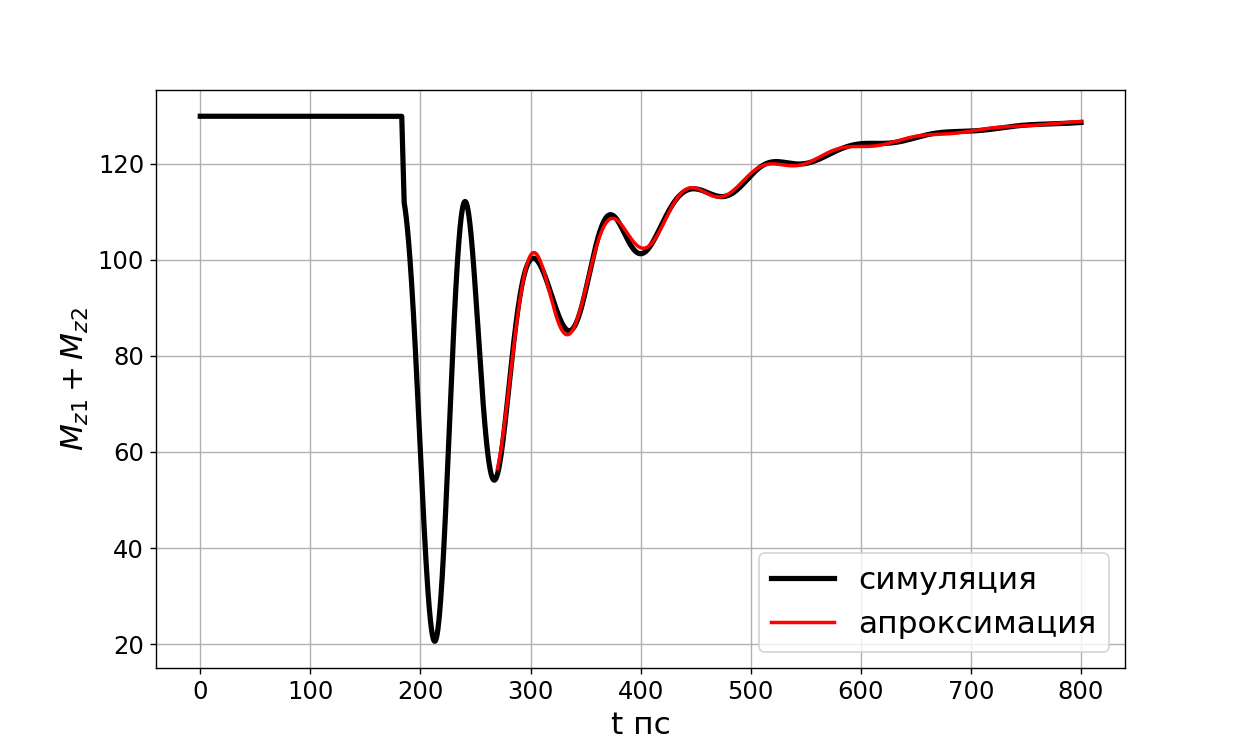

In [54]:
%matplotlib notebook
plt.subplots(figsize = (10, 6))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


what_to = df.z2 + df.z1
#what_to = df.z2

plt.plot(df.t*1e12, what_to, label="симуляция", linewidth=3,color='k')
plt.xlabel("t пс", fontsize=18)
plt.ylabel(r"$M_{z1}+M_{z2}$", fontsize=18)
#plt.plot(df.t, df.z1)
#plt.plot(df.t, df.z2)
plt.grid(True)


In [55]:
from scipy.optimize import curve_fit
import matplotlib.patheffects as pe

##---------WARNING----------
#print("WARNING")
M_t0 = 270e-12
#print("M_t0 set to {}".format(M_t0))
#print()
##---------WARNING----------

def func3(x, fi0, f, tau1, tau2, tau3, A1, A2, A3, C):
    #       1-oscillations                                      2-M relaxation              3-Ku relaxation
    return A1*np.exp(-x/tau1)*np.cos(2*np.pi*f*x + fi0) + C + A2*np.exp(-(x-M_t0)/tau2) + A3*np.exp(-(x-Ku_t0)/tau3)

def func2(x, fi0, f, tau1, tau2,  A1, A2, C):
    #       1-oscillations                                      2-M relaxation         
    return A1*np.exp(-x/tau1)*np.cos(2*np.pi*f*x + fi0) + C + A2*np.exp(-(x-M_t0)/tau2) 

def func1(x, fi0, f, tau1, A1, C):
    #       1-oscillations                                      2-M relaxation         
    return A1*np.exp(-x/tau1)*np.cos(2*np.pi*f*x + fi0) + C


#par, ss = curve_fit(
#    func3,
#    df.t[df.t>M_t0],
#    what_to[df.t>M_t0],
#    # 1 - oscillation, 2 - M relaxation, 3 - Ku relaxation
#    #  fi0, f,   tau1,    tau2,  tau3,   A1, A2, A3, C
#    #p0=[0, 60e9, 25-12, M_tau, Ku_tau, 30., 1., 0., 400.],
#    p0=[0, 12e9, 25e-12, 10e-12, Ku_tau, 20., 0., 0., 100.],
#    maxfev=1000
#)

par, ss = curve_fit(
    func2,
    df.t[df.t>M_t0],
    what_to[df.t>M_t0],
    # 1 - oscillation, 2 - M relaxation, 3 - Ku relaxation
    #   fi0, f,   tau1,    tau2, A1, A2,  C
    p0=[0, 12e9, 100e-12, 10e-12, 20., -0., 500.],
    maxfev=1000
)


#par, ss = curve_fit(
#    func1,
#    df.t[df.t>M_t0],
#    what_to[df.t>M_t0],
#    # 1 - oscillation, 2 - M relaxation, 3 - Ku relaxation
#    #  fi0, f,   tau1,    tau2,  tau3,   A1, A2, A3, C
#    #p0=[0, 60e9, 25-12, M_tau, Ku_tau, 0.1., 1., 0., 400.],
#    p0=[0, 15e9, 25e-12, 1., 475.],
#    maxfev=1000,
#)

print(par)
print("f={} GHz".format(par[1]*1e-9))
print("tau_f={} ps".format(par[2]*1e12))

#plt.plot(df.t[df.t>M_t0]*1e12, func3(df.t[df.t>M_t0], *par), '-.', label='апроксимация', linewidth=2, color='red')
plt.plot(df.t[df.t>M_t0]*1e12, func2(df.t[df.t>M_t0], *par), linestyle='-', linewidth=2, color='red', label='апроксимация')
#plt.plot(df.t[df.t>M_t0]1e12, func1(df.t[df.t>M_t0], *par))

plt.legend(fontsize=18)

[-1.83327971e+00  1.42015474e+10  8.79485136e-11  1.67344059e-10
  4.61365223e+02 -5.38253987e+01  1.31009738e+02]
f=14.201547381117816 GHz
tau_f=87.94851355819964 ps


17.499825

'delta: 1.2499875'

<IPython.core.display.Javascript object>


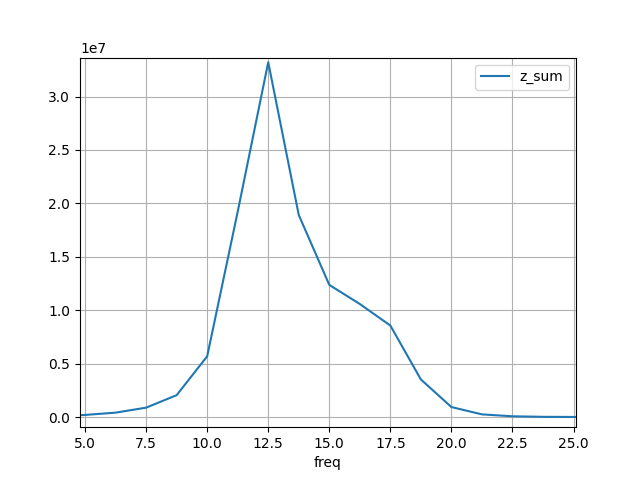

In [336]:
%matplotlib notebook
freq_df = pd.DataFrame(columns=['freq','x1','y1','z1','x2','y2','z2'])

freq_df['freq'] = np.fft.fftfreq(len(df.t), df.t[1]-df.t[0])[1:200] * 1e-9

column_names = ['x1','y1','z1','x2','y2','z2']
for name in column_names:
    freq_df[name] = np.abs(np.fft.fft(df[name]))[1:200]**2

freq_df["z_sum"] = np.abs(np.fft.fft(df.z1 + df.z2))[1:200]**2

display(freq_df['freq'][freq_df['z1'].argmax()])
display("delta: {}".format(freq_df.freq[1]-freq_df.freq[0]))
#freq_df.plot(x='freq', y=['x1','y1', 'z1', 'x2', 'y2', 'z2'])
freq_df.plot(x='freq', y=['z_sum'])
plt.grid(True)

In [25]:
%matplotlib notebook
#for now not valid for dynamic parameters
Es_of_tragectory = st_state.Es_lamb(
    df.x1, df.y1, df.z1,
    df.x2, df.y2, df.z2,
    Hext[0], Hext[1], Hext[2],
    film_inst.l1.st.Ku, film_inst.l2.st.Ku,
    film_inst.J,
    film_inst.l1.st.t, film_inst.l2.st.t
)

Es_of_tragectory.plot(figsize = (9,3))
plt.grid(True)


AttributeError: 'StaticMaterial' object has no attribute 'Ku'

<IPython.core.display.Javascript object>


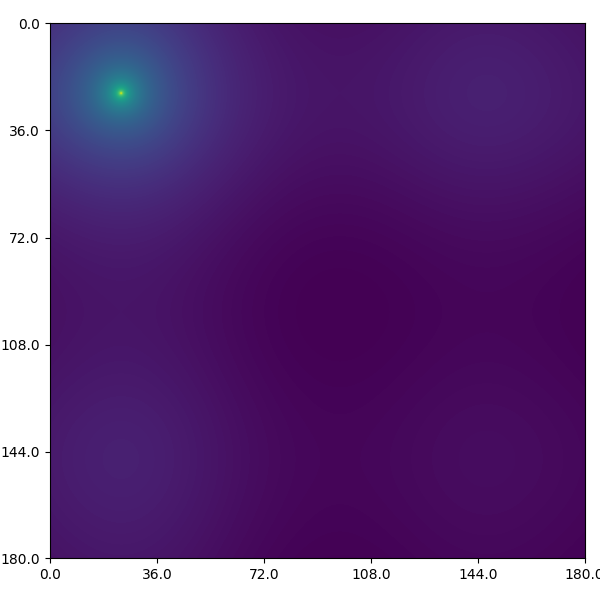

||H|| = 1500.0


In [126]:
%matplotlib notebook

st_state.plot_energy(
    film_inst,
    Hext,
    
    N = 1000,
    ang0_diap_grad = np.array([0., 180.]),
    ang1_diap_grad = np.array([0., 180.]),
    sign = -1
)
print("||H|| = {}".format(Hext_abs))

<IPython.core.display.Javascript object>


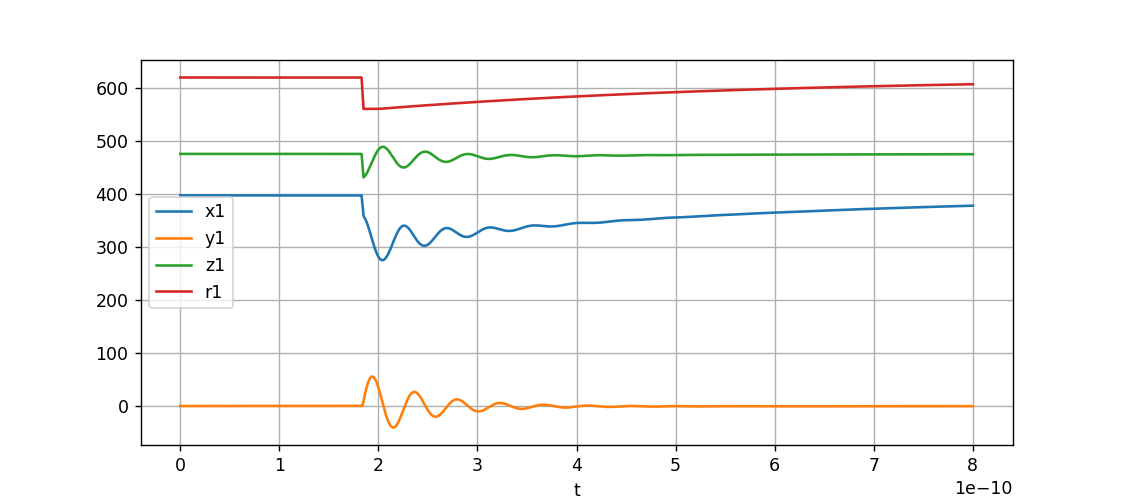

In [33]:
%matplotlib notebook

df.plot(x='t', y=['x1', 'y1', 'z1', 'r1'], figsize = (9, 4))
plt.grid(True)

<IPython.core.display.Javascript object>


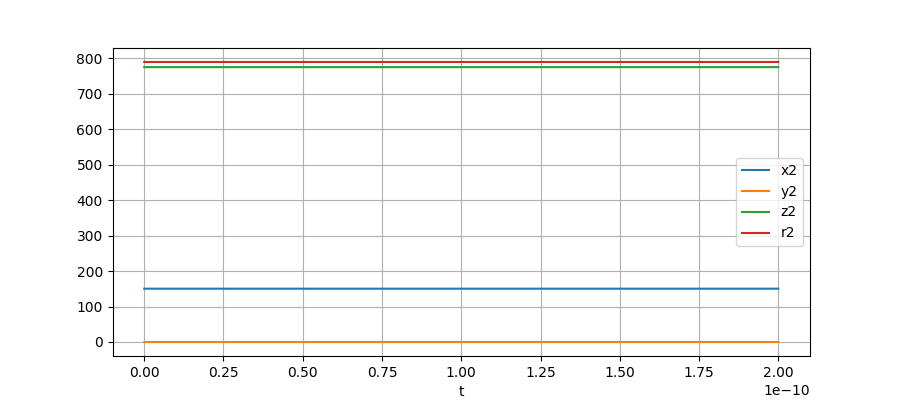

In [101]:
%matplotlib notebook

df.plot(x='t', y=['x2', 'y2', 'z2', 'r2'], figsize = (9, 4))
plt.grid(True)

# Legacy Code

In [14]:
Heff_function(M01, M02, film_inst, 0)

(array([-1097.38839482,     0.        , -2645.81983107]),
 array([-1097.38839482,     0.        , -2645.81983107]))

<IPython.core.display.Javascript object>


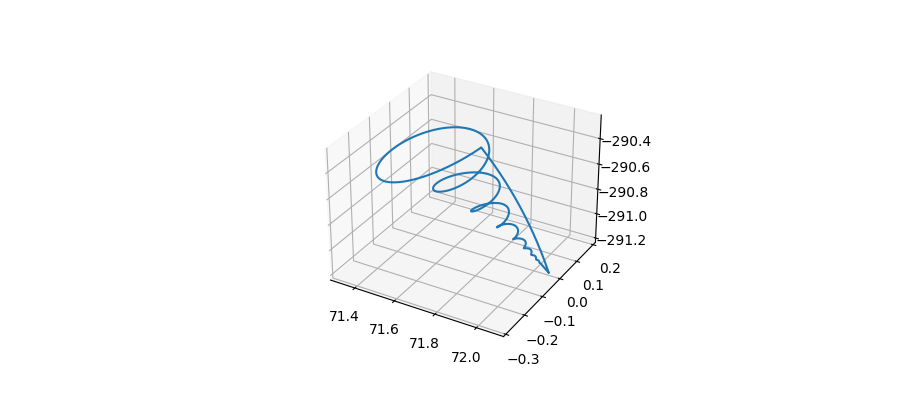

In [37]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(9,4), dpi= 100, facecolor='w', edgecolor='k')

ax = fig.add_subplot(111, projection='3d')
ax.plot(sol.y[0], sol.y[1], sol.y[2])

In [6]:
%load_ext jupyter_spaces

In [91]:
%%space space1

S = CoordSys3D('S')

Mx, My, Mz = symbols("M_x M_y M_z")
M = S.i*Mx + S.j*My + S.k*Mz

Hx, Hy, Hz = symbols("H_x H_y H_z")
H = S.i*Hx + S.j*Hy + S.k*Hz

Ku = symbols("K_u")

sin_tet2 = (Mx**2 + My**2)/(Mx**2 + My**2 + Mz**2)
Ev = -H.dot(M) + 2*sym.pi*(M.dot(S.k)**2) + Ku*sin_tet2

varset = (
    Mx, My, Mz,
    Hx, Hy, Hz,
    Ku
)
Ev_lamb = lambdify(varset, Ev)



-H_x*M_x - H_y*M_y - H_z*M_z + K_u*(M_x**2 + M_y**2)/(M_x**2 + M_y**2 + M_z**2) + 2*pi*M_z**2

In [ ]:
%%space space2
